In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell
from common.calculate_variance import calculate_variance

import datetime as dt

InteractiveShell.ast_node_interactivity = "all"

In [68]:
# data 기초 전처리
data = pd.read_csv('../data/AAPL.csv')
data = data.set_index('Date')

# 인덱스를 datetime으로 변경
data.index = pd.to_datetime(data.index)

# test 셋과 train 셋으로 나누기
split_date= dt.datetime(2011,12,5)
train_data = data[data.index<split_date]
test_data = data[data.index>=split_date]

# log 수익률 column 추가
train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
train_data_return = train_data['log_price_return'].dropna()

test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)
test_data_return = test_data['log_price_return'].dropna()


/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_60858/1000520923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_60858/1000520923.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)


In [69]:
# dataset 만들기
# train
train_data_set = pd.DataFrame()
var = calculate_variance(train_data_return)
train_data_set['rv'] = np.sqrt(var)
train_data_set['log_return'] = train_data_return
# test
test_data_set = pd.DataFrame()
var = calculate_variance(test_data_return)
test_data_set['rv'] = np.sqrt(var)
test_data_set['log_return'] = test_data_return


In [70]:
# scaling 
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_data_minmax = scaler_minmax.fit_transform(train_data_set)
test_data_minmax = scaler_minmax.transform(test_data_set)

# 정규화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_data_df = pd.DataFrame(train_data_minmax, index=train_data_set.index,columns=train_data_set.columns)
test_data_df = pd.DataFrame(test_data_minmax, index=test_data_set.index,columns=test_data_set.columns)

In [71]:
train_x = train_data_df[['rv', 'log_return']].values
train_y = train_data_set['rv'].values

test_x = test_data_df[['rv', 'log_return']].values
test_y = test_data_set['rv'].values

def seq_data(x,y,sequence_length,time_interval):
    x_seq = []
    y_seq = []

    for i in range(len(x) - time_interval):
        x_seq.append(x[i: i+sequence_length])
        y_seq.append(y[i+time_interval])

    return np.array(x_seq).reshape(-1, 2*sequence_length), np.array(y_seq).reshape(-1, 1)

# inputs of 4
sequence_length = 1
# third day forecasting
time_interval = sequence_length + 2


trainX,trainY = seq_data(train_x,train_y,sequence_length,time_interval)
testX,testY = seq_data(test_x,test_y,sequence_length,time_interval)


In [72]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

SVR_parameters = [{"C" : [0.1, 1, 10, 100, 1000], "gamma" : [0.0000001,0.000001,0.0001,0.01,1,100,10000,1000000], "nu": [0.1,0.2,0.3,0.4,0.5]}]

tscv = TimeSeriesSplit(n_splits=5)

#모델 생성
svr_rbf = NuSVR(kernel='rbf',max_iter=10000)

#RMSE 평가 지표 함수 
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred,squared=False)), greater_is_better=False)

grid_search = GridSearchCV(estimator=svr_rbf, param_grid=SVR_parameters,scoring=rmse_scorer, cv=tscv)

In [73]:
y_rbf = grid_search.fit(trainX,trainY.flatten())
predicted_y = y_rbf.predict(testX)

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScale

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

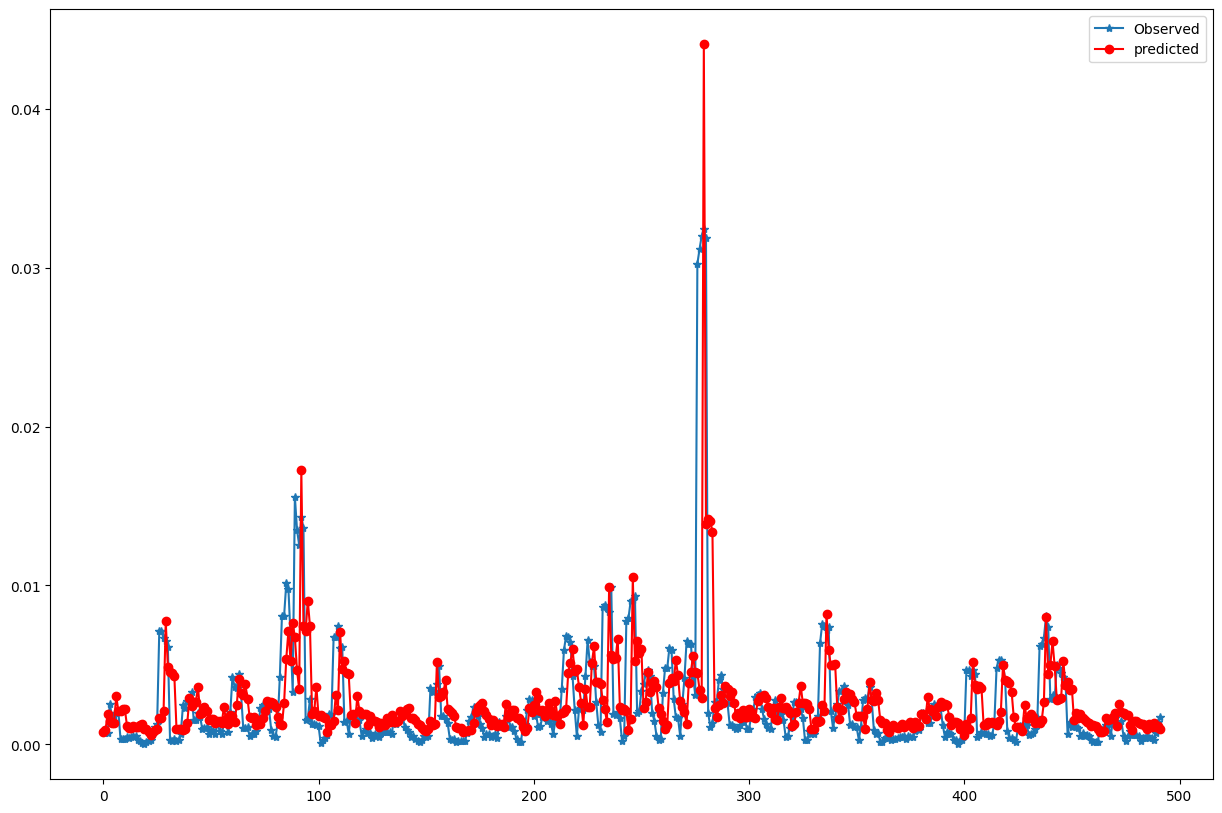

In [74]:
rv_train = pd.DataFrame(train_data_set['rv'])
scaler_result = MinMaxScaler()
scaler_result.fit(rv_train)

df_y = scaler_result.transform(predicted_y.reshape(-1,1))

plt.figure(figsize=(15,10))
plt.plot(test_data_df[time_interval:].rv.values**2,marker='*', label = "Observed")
plt.plot(df_y**2,marker='o', label = "predicted", color='red')
plt.legend()

In [75]:
mean_squared_error(df_y,test_data_df[time_interval:].rv.values,squared=False)

0.02294590020414638

<Figure size 1500x1000 with 0 Axes>

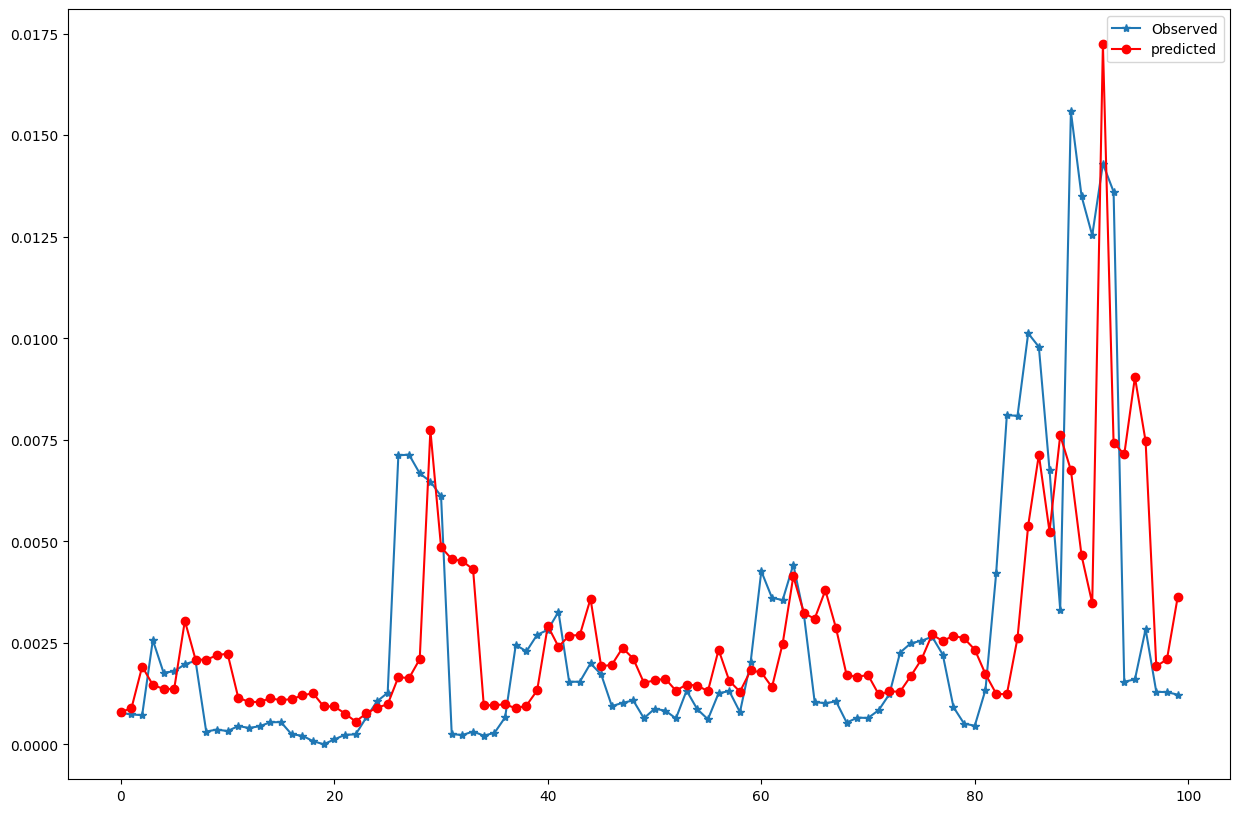

In [76]:
plt.figure(figsize=(15,10))
plt.plot(test_data_df[time_interval:100+time_interval].rv.values**2,marker='*', label = "Observed")
plt.plot(df_y[:100]**2,marker='o', label='predicted', color='red')
plt.legend()

In [77]:
grid_search.best_params_

{'C': 10, 'gamma': 1, 'nu': 0.5}

In [78]:
len(test_data_df[time_interval:100+time_interval])

100

In [79]:
len(df_y)

492